In [1]:
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux: logitbinarycrossentropy
using Images
using MLDatasets
using Statistics
using Parameters: @with_kw
using Printf
using Random
import ProgressMeter
using Plots
import GR
gr()

Plots.GRBackend()

# Loading data

In [11]:
directory_path = "/media/subhaditya/DATA/COSMO/Datasets/celebAsubset/trainB"
directory_files = readdir(directory_path);

In [27]:
size(directory_files)[1]

10001

In [13]:
directory_images = filter(x -> occursin(r"\.(jpg|png|gif){1}$"i, x), directory_files);

In [150]:
all_images = []

0-element Array{Any,1}

In [151]:
p = ProgressMeter.Progress(size(directory_images)[1])
for image_name in directory_images
    image_path = joinpath(directory_path, image_name)
    image = load(image_path);
#     display(image)
    image = imresize(image, (128,128))
    
#     @info size(image)
#     break
    push!(all_images, image)
    ProgressMeter.next!(p)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


In [60]:
function showBatch(noImages,arr)
    p = plot(axis = nothing,layout = noImages);

    for x in 1:noImages
        plot!(p[x],arr[x])
    
    end
    display(p)
end

showBatch (generic function with 1 method)

In [103]:
size(all_images)

(10000,)

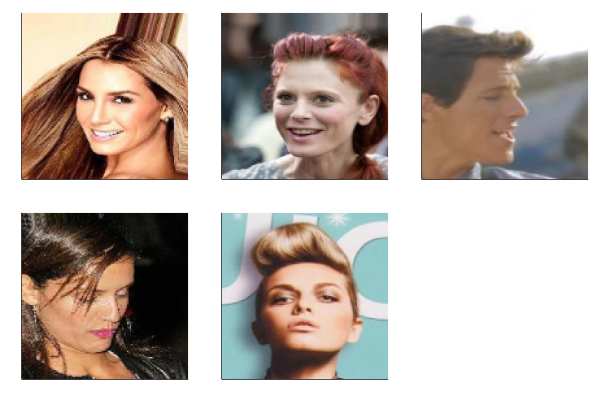

In [62]:
showBatch(5, all_images)

In [154]:
preprocess(img) = vec(Float64.(convert(Array{Float64},channelview(img));))

preprocess (generic function with 1 method)

In [160]:
function preprocess2(img)
    return hcat(float.(img)...)
end

preprocess2 (generic function with 1 method)

In [155]:
all_images = preprocess.(all_images);

In [162]:
preprocess2(all_images[1])

1×49152 Array{Float64,2}:
 0.992157  0.905882  0.760784  0.992157  …  0.466667  0.196078  0.0941176

In [163]:
all_images = preprocess2.(all_images);

In [167]:
typeof(all_images[1])

Array{Float64,2}

# Gan part

In [28]:
using DiffEqFlux
using DifferentialEquations

In [6]:
@with_kw struct HyperParams
    batch_size::Int = 128
    latent_dim::Int = 100
    epochs::Int = 20
    verbose_freq::Int = 1000
    output_x::Int = 6
    output_y::Int = 6
    lr_dscr::Float64 = 0.0002
    lr_gen::Float64 = 0.0002
end

HyperParams

In [7]:
function create_output_image(gen, fixed_noise, hparams)
    @eval Flux.istraining() = false
    fake_images = @. cpu(gen(fixed_noise))
    @eval Flux.istraining() = true
    image_array = permutedims(dropdims(reduce(vcat, reduce.(hcat, partition(fake_images, hparams.output_y))); dims=(3, 4)), (2, 1))
    image_array = @. Gray(image_array + 1f0) / 2f0
    return image_array
end

create_output_image (generic function with 1 method)

In [18]:
function Discriminator(hparams)
    return Chain(
            Conv((4, 4), 1 => 64; stride = 2, pad = 1),
            x->leakyrelu.(x, 0.2f0),
            Dropout(0.25),
            Conv((4, 4), 64 => 128; stride = 2, pad = 1),
            x->leakyrelu.(x, 0.2f0),
            Dropout(0.25), 
            x->reshape(x, 7 * 7 * 128, :),
            Dense(7 * 7 * 128, 1))	
end

Discriminator (generic function with 2 methods)

In [19]:
function Generator(hparams)
    return Chain(
            Dense(hparams.latent_dim, 7 * 7 * 256),
            BatchNorm(7 * 7 * 256, relu),
            x->reshape(x, 7, 7, 256, :),
#             x -> concrete_solve(prob,Tsit5(),x,p,saveat=0.1)[1,:],
            ConvTranspose((5, 5), 256 => 128; stride = 1, pad = 2),
            BatchNorm(128, relu),
            ConvTranspose((4, 4), 128 => 64; stride = 2, pad = 1),
            BatchNorm(64, relu),
            ConvTranspose((4, 4), 64 => 1, tanh; stride = 2, pad = 1),
            )
end

Generator (generic function with 2 methods)

In [20]:
# Loss functions
function discriminator_loss(real_output, fake_output)
    real_loss = mean(logitbinarycrossentropy.(real_output, 1f0))
    fake_loss = mean(logitbinarycrossentropy.(fake_output, 0f0))
    return real_loss + fake_loss
end

discriminator_loss (generic function with 1 method)

In [21]:
generator_loss(fake_output) = mean(logitbinarycrossentropy.(fake_output, 1f0))

generator_loss (generic function with 1 method)

In [22]:
function train_discriminator!(gen, dscr, x, opt_dscr, hparams)
    noise = randn!(similar(x, (hparams.latent_dim, hparams.batch_size))) 
    fake_input = gen(noise)
    ps = Flux.params(dscr)
    # Taking gradient
    loss, back = Flux.pullback(ps) do
        discriminator_loss(dscr(x), dscr(fake_input))
    end
    grad = back(1f0)
    update!(opt_dscr, ps, grad)
    return loss
end

train_discriminator! (generic function with 1 method)

In [23]:
function train_generator!(gen, dscr, x, opt_gen, hparams)
    noise = randn!(similar(x, (hparams.latent_dim, hparams.batch_size))) 
    ps = Flux.params(gen)
    # Taking gradient
    loss, back = Flux.pullback(ps) do
        generator_loss(dscr(gen(noise)))
    end
    grad = back(1f0)
    update!(opt_gen, ps, grad)
    return loss
end

train_generator! (generic function with 1 method)

In [26]:
function train(; kws...)
    # Model Parameters
    hparams = HyperParams(; kws...)

    # Load MNIST dataset
    images, _ = MLDatasets.MNIST.traindata(Float32)
    # Normalize to [-1, 1]
    image_tensor = reshape(@.(2f0 * images - 1f0), 28, 28, 1, :)
    # Partition into batches
    data = [image_tensor[:, :, :, r] |> gpu for r in partition(1:60000, hparams.batch_size)]

    fixed_noise = [randn(hparams.latent_dim, 1) |> gpu for _=1:hparams.output_x*hparams.output_y]

    # Discriminator
    dscr = Discriminator(hparams) |> gpu

    # Generator
    gen =  Generator(hparams) |> gpu

    # Optimizers
    opt_dscr = ADAM(hparams.lr_dscr)
    opt_gen = ADAM(hparams.lr_gen)

    # Training
    train_steps = 0
    p = ProgressMeter.Progress(hparams.epochs)
    for ep in 1:hparams.epochs
        @info "Epoch $ep"
        for x in data
            # Update discriminator and generator
            loss_dscr = train_discriminator!(gen, dscr, x, opt_dscr, hparams)
            loss_gen = train_generator!(gen, dscr, x, opt_gen, hparams)

            if train_steps % hparams.verbose_freq == 0
                @info("Train step $(train_steps), Discriminator loss = $(loss_dscr), Generator loss = $(loss_gen)")
                # Save generated fake image
                output_image = create_output_image(gen, fixed_noise, hparams)
                save(@sprintf("output/dcgan_steps_%06d.png", train_steps), output_image)
            end
            train_steps += 1
        end
        ProgressMeter.next!(p)
    end

    output_image = create_output_image(gen, fixed_noise, hparams)
    save(@sprintf("output/dcgan_steps_%06d.png", train_steps), output_image)
end

train (generic function with 1 method)

In [29]:
# cd(@__DIR__)
train()

┌ Info: Epoch 1
└ @ Main In[26]:28


UndefVarError: UndefVarError: prob not defined